# Нотбук с обучением модели

#### Импорты

In [ ]:
import time
import warnings
from collections import defaultdict
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision import models
import albumentations as A
from torchinfo import summary  # не забудьте выполнить pip install torchinfo
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models import efficientnet_b7
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision import datasets, transforms, models


from torch.utils.data import Dataset, DataLoader

from IPython.display import clear_output

from PIL import Image

In [ ]:
sns.set(font_scale=1, style="darkgrid", palette="Set2")
warnings.simplefilter("ignore")

device = torch.device('mps') if torch.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Датасет

#### Создадим отдельный класс для нашего датасета, чтобы иметь контроль над преобразованиями

In [5]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, is_val=False, transform=None):
        data = pd.read_csv(csv_file)
        if is_val:
            self.data = data.iloc[:int(len(data) * 0.2)]
        else:
            self.data = data.iloc[int(len(data) * 0.8):]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        label = row['emotion']
        image = [float(x) for x in row['pixels'].split()]
        image = np.array(image).reshape(48, 48).astype(np.uint8)
        # image = Image.fromarray(image).convert('L')

        if self.transform:
            image = self.transform(image=image)

        return image, torch.tensor(label, dtype=torch.long)

#### Аугментации

In [ ]:
image_size = 384

def l_repeat(image, **kwargs):
    image = image.reshape((-1, 1, image_size, image_size))
    return torch.tensor(np.repeat(image, 3, axis=1))

def l_repeat_val(image, **kwargs):
    image = image.reshape((-1, 1, image_size, image_size))
    return torch.tensor(np.repeat(image, 3, axis=1))


transform_train = A.Compose([
    A.Resize(image_size, image_size), 
    A.VerticalFlip(p=0.5),
    A.GaussNoise(var_limit=(5.0, 10.0), p=0.3),
    A.CLAHE(clip_limit=2.0, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.ElasticTransform(alpha=1.0, sigma=50, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.3),
    A.Normalize((0.5,), (0.5,)),  # Normalize using ImageNet stats
    A.Lambda(name='l_repeat', image=l_repeat, p=1),  # Repeat channels
])

transform_val = A.Compose([
    A.Resize(image_size, image_size),  # Resize images to 224x224
    A.Normalize((0.5,), (0.5,)),  # Normalize using ImageNet stats
    A.Lambda(name='l_repeat_val', image=l_repeat_val, p=1),  # Repeat channels
])

#### Создадим датасет

In [ ]:
train_url = "/Users/misha/Downloads/Telegram Desktop/train.csv"
val_url = "/Users/misha/Downloads/Telegram Desktop/train.csv"

train_dataset = CustomDataset(train_url)
val_dataset = CustomDataset(val_url, is_val=True)

# Классы объектов в датасете
classes = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral",
}

In [ ]:
batch_size = 64

train_dataset = CustomDataset(train_url, transform=transform_train)
val_dataset = CustomDataset(val_url, is_val=True, transform=transform_val)

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True,
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, drop_last=True,
)


### Обучение модели

#### Введем вспомогательные функции для обучения

In [ ]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(
    X_batch, y_batch, model, criterion, current_loss, current_acc
):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))


    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc



In [ ]:
def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown"]
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(
            history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(
            history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

#### Введем основной цикл обучения

In [ ]:
def train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=10
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        for X_batch, y_batch in train_batch_gen:
            X_batch = X_batch['image'].squeeze(dim=1)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )


            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        update_history(
            history, train_loss, train_acc, len(train_batch_gen), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_batch_gen:
                X_batch = X_batch['image'].squeeze(dim=1)
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        clear_output()
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

        plot_histories([history], ["CNN"])

    return history

In [ ]:
class CustomModel(torch.nn.Module):

    def __init__(self):
        super(CustomModel, self).__init__()

        # Введем backbone
        self.resnet = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)
        self.head = nn.Sequential(
            nn.Linear(in_features=1000, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=7),
        ).to(device)


        for param in list(self.resnet.parameters())[:-20]:
            param.requires_grad = False

        for param in list(self.resnet.parameters())[-20:]:
            param.requires_grad = True

        # Голову обучаем
        for param in self.head.parameters():
            param.requires_grad = True

    def forward(self, x):
        x = self.resnet(x)
        x = self.head(x)

        return x


#### Параметры обучения

Epoch 50 of 50 took 680.495 s
  training loss: 	0.111084
  validation loss: 	2.170608
  training accuracy: 			96.19 %
  validation accuracy: 			59.76 %


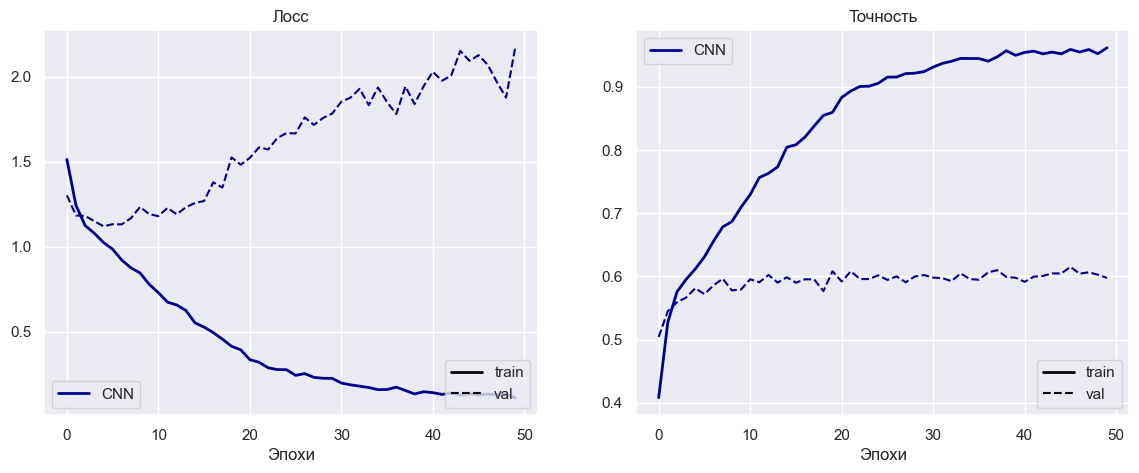

: 

In [ ]:
model = CustomModel()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

history_cnn = train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=50,
)

torch.save(model.state_dict(), "simple_cnn.pth")

**Видно что модель уже переобучилась -- на трейне лосс падает, а на валидации нет**

##### Посмотрим на confusion matrix

In [ ]:
model_path = "/Users/misha/Downloads/simple_cnn.pth"

model = CustomModel()
model.load_state_dict(torch.load(model_path, weights_only=True))
model.to(device)


CustomModel(
  (resnet): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): La

In [35]:
import sklearn
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


y_pred = []
model.eval()
for i in tqdm(range(len(val_dataset))):
    label = np.argmax(model(val_dataset[i][0]['image'].to(device)).detach().cpu().numpy())
    y_pred.append(label)

100%|██████████| 5741/5741 [05:21<00:00, 17.84it/s]


In [ ]:
y_true = [int(val_dataset[i][1].detach().cpu().numpy()) for i in range(len(val_dataset))]

cm = confusion_matrix(y_true, y_pred,  normalize='all')

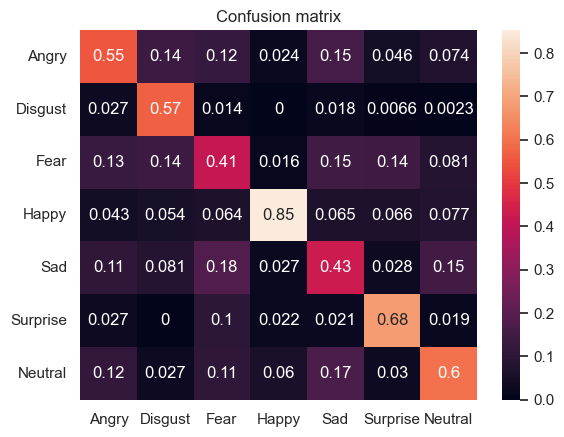

In [71]:
sns.heatmap(cm, annot=True,
            xticklabels=["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"], 
            yticklabels=["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"])
plt.title("Confusion matrix")
plt.show()

Легко заметить что качество в среднем определяется неплохо, Happy определяется лучше всего -- в 85% случаев, Fear хуже всего, но его путают не с каким-то конкретным классом а примерно со всеми понемногу